# Hyperparameter Tuning for Sentiment Analysis

This notebook demonstrates hyperparameter optimization for a Logistic Regression model to perform sentiment analysis. We'll track experiments with MLflow and find the best model configuration.

## Setup and Imports

In [1]:
import numpy as np
import mlflow
import pandas as pd

import sys
sys.path.append('..')
from src.models.train_models import ModelTrainer
from src.models.predict_models import ModelPredictor
from src.config import *

## Define Hyperparameter Grid

We'll create a grid of hyperparameters to search through:

- **C values**: Regularization strength (inverse) - smaller values specify stronger regularization
- **Penalty types**: The norm used in penalization (L1 or L2)
- **Solver algorithms**: Algorithm for optimization

In [2]:
# Define hyperparameter grids to search
C_values = [0.1, 0.5, 1.0, 2.0, 5.0]
penalty_values = ['l1', 'l2']
solver_values = ['liblinear', 'saga']

## Hyperparameter Grid Search

Now we'll run through all valid combinations of hyperparameters and track the results using MLflow.

In [3]:
results = []

for c in C_values:
    for penalty in penalty_values:
        for solver in solver_values:
            # Skip invalid combinations for solvers
            if solver == 'liblinear' and penalty == 'elasticnet':
                continue
            if solver == 'saga' and penalty not in ['l1', 'l2', 'elasticnet', 'none']:
                continue
            if solver != 'liblinear' and penalty == 'l1': # Only liblinear and saga support l1
                if solver != 'saga':
                    continue

            print(f"Training with C={c}, Penalty={penalty}, Solver={solver}")
            try:
                run_id = ModelTrainer.logistic_regression(C=c, penalty=penalty, solver=solver)

                with mlflow.start_run(run_id=run_id):
                    run = mlflow.get_run(run_id)
                    metrics = run.data.metrics
                    params = run.data.params

                    results.append({
                        'run_id': run_id,
                        'C': params.get('C'),
                        'penalty': params.get('penalty'),
                        'solver': params.get('solver'),
                        'train_accuracy': metrics.get('train_accuracy'),
                        'test_accuracy': metrics.get('test_accuracy'),
                        'test_precision': metrics.get('test_precision'),
                        'test_recall': metrics.get('test_recall'),
                        'test_f1': metrics.get('test_f1'),
                    })
            except Exception as e:
                print(f"Error training with C={c}, Penalty={penalty}, Solver={solver}: {e}")
                continue

Training with C=0.1, Penalty=l1, Solver=liblinear
Creating new MLflow experiment 'sentiment_classification'...
Training with C=0.1, Penalty=l1, Solver=saga
Using active MLflow experiment 'sentiment_classification' with ID 360311621043028179
Training with C=0.1, Penalty=l2, Solver=liblinear
Using active MLflow experiment 'sentiment_classification' with ID 360311621043028179
Training with C=0.1, Penalty=l2, Solver=saga
Using active MLflow experiment 'sentiment_classification' with ID 360311621043028179
Training with C=0.5, Penalty=l1, Solver=liblinear
Using active MLflow experiment 'sentiment_classification' with ID 360311621043028179
Training with C=0.5, Penalty=l1, Solver=saga
Using active MLflow experiment 'sentiment_classification' with ID 360311621043028179
Training with C=0.5, Penalty=l2, Solver=liblinear
Using active MLflow experiment 'sentiment_classification' with ID 360311621043028179
Training with C=0.5, Penalty=l2, Solver=saga
Using active MLflow experiment 'sentiment_classif

/home/khoa/Projects/VSCODE/HCMUT/ML Assignment/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training with C=2.0, Penalty=l2, Solver=liblinear
Using active MLflow experiment 'sentiment_classification' with ID 360311621043028179
Training with C=2.0, Penalty=l2, Solver=saga
Using active MLflow experiment 'sentiment_classification' with ID 360311621043028179
Training with C=5.0, Penalty=l1, Solver=liblinear
Using active MLflow experiment 'sentiment_classification' with ID 360311621043028179
Training with C=5.0, Penalty=l1, Solver=saga
Using active MLflow experiment 'sentiment_classification' with ID 360311621043028179


/home/khoa/Projects/VSCODE/HCMUT/ML Assignment/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training with C=5.0, Penalty=l2, Solver=liblinear
Using active MLflow experiment 'sentiment_classification' with ID 360311621043028179
Training with C=5.0, Penalty=l2, Solver=saga
Using active MLflow experiment 'sentiment_classification' with ID 360311621043028179


## Print All Model Test Accuracies

Let's display the test accuracies for all models, sorted by performance.


All Models Test Accuracies (sorted):

  C penalty    solver  test_accuracy
5.0      l2      saga       0.878992
5.0      l2 liblinear       0.878992
2.0      l2      saga       0.875499
2.0      l2 liblinear       0.875250
5.0      l1 liblinear       0.873503
5.0      l1      saga       0.872255
2.0      l1      saga       0.871507
2.0      l1 liblinear       0.871507
1.0      l1 liblinear       0.868014
1.0      l1      saga       0.868014
1.0      l2      saga       0.867265
1.0      l2 liblinear       0.867265
0.5      l1      saga       0.855788
0.5      l1 liblinear       0.855788
0.5      l2      saga       0.850549
0.5      l2 liblinear       0.850299
0.1      l2 liblinear       0.788174
0.1      l2      saga       0.787425
0.1      l1 liblinear       0.786677
0.1      l1      saga       0.786427


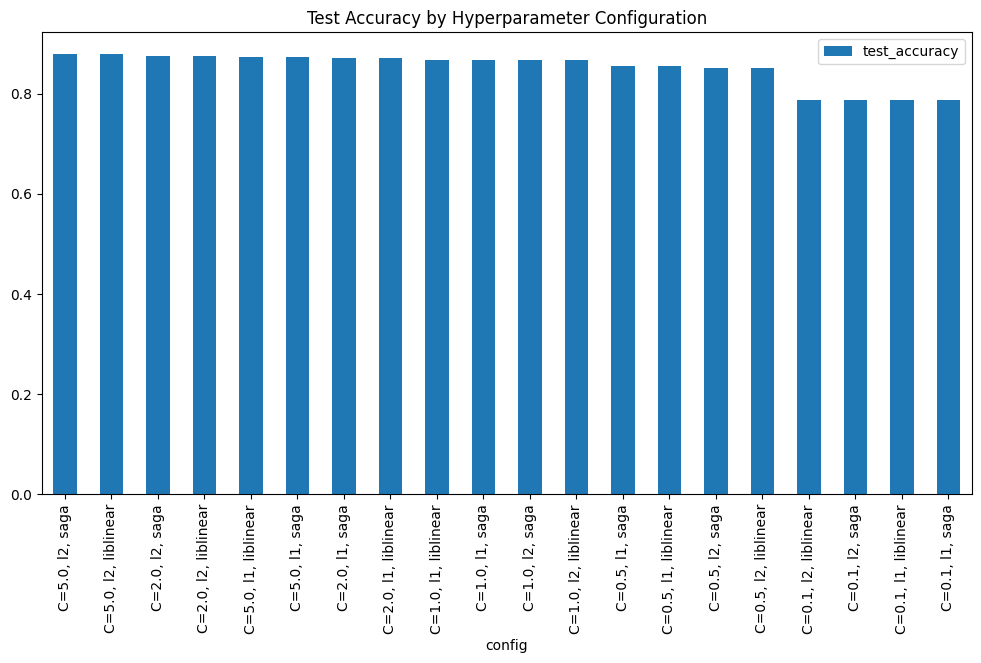

In [4]:
# Create dataframe from results
results_df = pd.DataFrame(results)

# Print all model test accuracies, sorted from best to worst
if not results_df.empty and 'test_accuracy' in results_df.columns:
    sorted_results = results_df.sort_values('test_accuracy', ascending=False)
    
    print("\nAll Models Test Accuracies (sorted):\n")
    print(sorted_results[['C', 'penalty', 'solver', 'test_accuracy']].to_string(index=False))
    
    # Create a combined label for each configuration
    sorted_results['config'] = sorted_results.apply(
        lambda row: f"C={row['C']}, {row['penalty']}, {row['solver']}", axis=1)
    
    # Plot with the combined label
    sorted_results.plot(
        kind='bar', x='config', y='test_accuracy', figsize=(12, 6),
        title='Test Accuracy by Hyperparameter Configuration'
    )
else:
    print("\nNo successful model runs found with test_accuracy metric.")

## Analyzing Results and Finding the Best Model

In [5]:
# Find the best model
if not results_df.empty and 'test_accuracy' in results_df.columns:
    best_model = results_df.loc[results_df['test_accuracy'].idxmax()]
    best_run_id = best_model['run_id']
    
    print("\nBest model:")
    print(f"C: {best_model['C']}, Penalty: {best_model['penalty']}, Solver: {best_model['solver']}")
    
    # Print test metrics
    print(f"Test Accuracy: {best_model['test_accuracy']:.4f}")
    
    # Check and print other test metrics if they exist
    for metric in ['test_f1', 'test_precision', 'test_recall']:
        if metric in best_model:
            print(f"{metric.replace('_', ' ').title()}: {best_model[metric]:.4f}")
    
    # Print train metrics
    if 'train_accuracy' in best_model:
        print(f"Train Accuracy: {best_model['train_accuracy']:.4f}")
    
    # Check and print other train metrics if they exist
    for metric in ['train_f1', 'train_precision', 'train_recall']:
        if metric in best_model:
            print(f"{metric.replace('_', ' ').title()}: {best_model[metric]:.4f}")
    
    print(f"Run ID: {best_run_id}")
else:
    print("\nNo successful model runs found with test_accuracy metric.")
    best_run_id = None


Best model:
C: 5.0, Penalty: l2, Solver: liblinear
Test Accuracy: 0.8790
Test F1: 0.8734
Test Precision: 0.8743
Test Recall: 0.8790
Train Accuracy: 0.9468
Run ID: 6cbea0d0539c41aaa985b372b9ea8e4e


## Making Predictions with the Best Model

In [6]:
if best_run_id is not None:
    # Prediction with the best model found
    texts = np.array(["This product works great!", "Terrible experience..."])
    predictions = ModelPredictor.predict(best_run_id, texts)

    print(f"\nPredictions with Best Model (Run ID: {best_run_id[:8]}...):\n")
    for text, pred in zip(texts, predictions):
        sentiment = "Positive" if pred == 1 else "Negative"
        print(f"'{text}' -> {sentiment}")


Predictions with Best Model (Run ID: 6cbea0d0...):

'This product works great!' -> Positive
'Terrible experience...' -> Negative
